# Results analyses

This notebook was designed to take the predictions generated after training the models, and performing results analyses based on several metrics.

## Basic imports

In [1]:
import pandas as pd
from sklearn import metrics
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(precision=4, suppress=True)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-68p5r8ul because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Functions for classification models

Below are the definitions of functions to evaluate the classification models.

In [2]:
def eval_model(dfs):
    acc_list = list()
    bal_acc_list = list()
    prec_macro_list = list()
    prec_micro_list = list()
    rec_macro_list = list()
    f1_macro_list = list()
    f1_micro_list = list()
    
    for df in dfs:
        acc = metrics.accuracy_score(df['y_true'], df['y_pred'])
        balanced_acc = metrics.balanced_accuracy_score(df['y_true'], df['y_pred'])
        precision_macro = metrics.precision_score(df['y_true'], df['y_pred'], average='macro')
        recall_macro = metrics.recall_score(df['y_true'], df['y_pred'], average='macro')
        f1_macro = metrics.f1_score(df['y_true'], df['y_pred'], average='macro')
        f1_micro = metrics.f1_score(df['y_true'], df['y_pred'], average='micro')
        
        acc_list.append(acc)
        bal_acc_list.append(balanced_acc)
        prec_macro_list.append(precision_macro)
        rec_macro_list.append(recall_macro)
        f1_macro_list.append(f1_macro)
        f1_micro_list.append(f1_micro)

    print('Accuracy')
    print('Mean:', np.mean(acc_list), ', Std:', np.std(acc_list))
    print('Balanced accuracy')
    print('Mean:', np.mean(bal_acc_list), ', Std:', np.std(bal_acc_list))
    print('Precision macro')
    print('Mean:', np.mean(prec_macro_list), ', Std:', np.std(prec_macro_list))
    print('Recall macro')
    print('Mean:', np.mean(rec_macro_list), ', Std:', np.std(rec_macro_list))
    print('F1 macro')
    print('Mean:', np.mean(f1_macro_list), ', Std:', np.std(f1_macro_list))
    print('F1 micro')
    print('Mean:', np.mean(f1_micro_list), ', Std:', np.std(f1_micro_list))

In [3]:
def avg_cf(dfs, lbl_names=None):
    cf_list = list()
    
    for df in dfs:
        cf = metrics.confusion_matrix(df['y_true'], df['y_pred'],normalize='true')
        cf_list.append(cf)
    cf_mean = np.mean(cf_list, axis=0)
    
    fig, ax = plt.subplots()      
    sns.heatmap(cf_mean, vmin=0, vmax=1, annot=True, fmt='0.2f', cbar=False, cmap='coolwarm', ax=ax)
    if lbl_names is not None:
        ax.set_xticklabels(lbl_names)
        ax.set_yticklabels(lbl_names)
    plt.show()

In [4]:
from sklearn.dummy import DummyClassifier

def compute_dummy(df, strategy='prior'):
    clf = DummyClassifier(strategy=strategy)
    clf.fit(df['y_true'], df['y_true'])
    df['y_pred'] = clf.predict(df['y_true'])
    return df

In [5]:
def eval_all(base_paths, lbl_names=None, dummy_strategy=None):
    for base_path in base_paths:
        dfs = list()
        print('\n', base_path)
        for i in range(4):
            path = os.path.join(base_path, f'split_{i+1}', 'preds.csv')
            df = pd.read_csv(path, index_col=0)
            if dummy_strategy is not None:
                df = compute_dummy(df, dummy_strategy)
            dfs.append(df)
        eval_model(dfs)
        avg_cf(dfs, lbl_names=lbl_names)

# Evaluating models that classify the water level

Below, I evaluate the models aimed at, given an input image or a sequence of input images, classify it according to the water level.
So far, the classes are *low*, *medium*, *high* and *flood*.

In [6]:
base_paths = list()
base_paths.append('/models/flow_v0')
base_paths.append('/models/single_rgb_v1')
base_paths.append('/models/single_gray_flow_v0')
base_paths.append('/models/stack_flow_v0')


 /models/flow_v0
Accuracy
Mean: 0.9320598475256072 , Std: 0.03160453587939705
Balanced accuracy
Mean: 0.5390297689426399 , Std: 0.03885927410750043
Precision macro
Mean: 0.3145555383379591 , Std: 0.03811737687084649
Recall macro
Mean: 0.5390297689426399 , Std: 0.03885927410750043
F1 macro
Mean: 0.33913376548332086 , Std: 0.05614943224939343
F1 micro
Mean: 0.9320598475256072 , Std: 0.03160453587939705


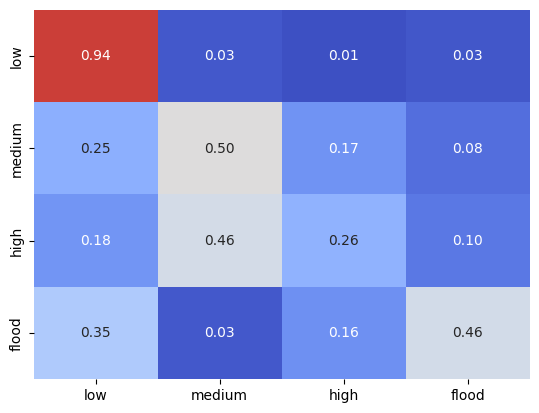


 /models/single_rgb_v1
Accuracy
Mean: 0.9575422839902221 , Std: 0.026900727588661237
Balanced accuracy
Mean: 0.6441085060695999 , Std: 0.062376137221326476
Precision macro
Mean: 0.46441243494058676 , Std: 0.12255792512622714
Recall macro
Mean: 0.6441085060695999 , Std: 0.062376137221326476
F1 macro
Mean: 0.48445719648954677 , Std: 0.10685096613971372
F1 micro
Mean: 0.9575422839902221 , Std: 0.026900727588661237


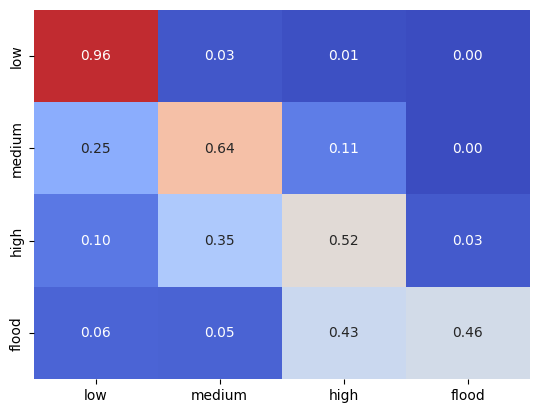


 /models/single_gray_flow_v0
Accuracy
Mean: 0.9301769317112671 , Std: 0.04278425378185786
Balanced accuracy
Mean: 0.6378865240438746 , Std: 0.08724746406621854
Precision macro
Mean: 0.3799414132343219 , Std: 0.06835367716714713
Recall macro
Mean: 0.6378865240438746 , Std: 0.08724746406621854
F1 macro
Mean: 0.41553684119090006 , Std: 0.06735377363194772
F1 micro
Mean: 0.9301769317112671 , Std: 0.04278425378185786


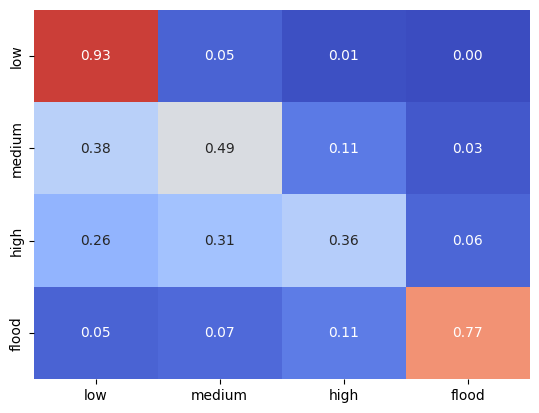


 /models/stack_flow_v0
Accuracy
Mean: 0.8677977459827528 , Std: 0.10866642813199748
Balanced accuracy
Mean: 0.5371739758008753 , Std: 0.09413757695018525
Precision macro
Mean: 0.3327150457821901 , Std: 0.053463609572528714
Recall macro
Mean: 0.5371739758008753 , Std: 0.09413757695018525
F1 macro
Mean: 0.35320393050675464 , Std: 0.08242696873320446
F1 micro
Mean: 0.8677977459827528 , Std: 0.10866642813199748


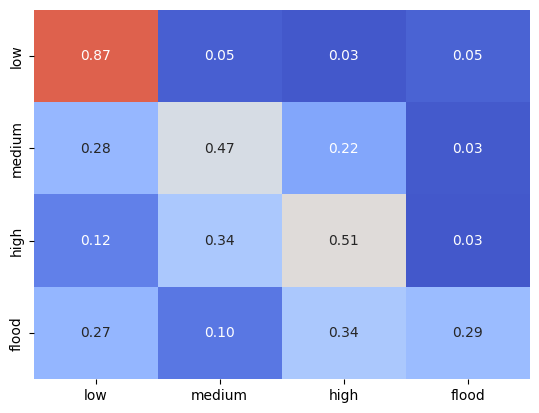

In [7]:
lbl_names = ['low', 'medium', 'high', 'flood']
eval_all(base_paths, lbl_names=lbl_names)

## Dummy classifiers

Here, I evaluate a set of dummy classifiers as baselines.


 /models/flow_v0
Accuracy
Mean: 0.9890806832949095 , Std: 0.002511393465124915
Balanced accuracy
Mean: 0.25 , Std: 0.0
Precision macro
Mean: 0.24727017082372738 , Std: 0.0006278483662812287
Recall macro
Mean: 0.25 , Std: 0.0
F1 macro
Mean: 0.24862719224464655 , Std: 0.00031703991883200633
F1 micro
Mean: 0.9890806832949095 , Std: 0.002511393465124915


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

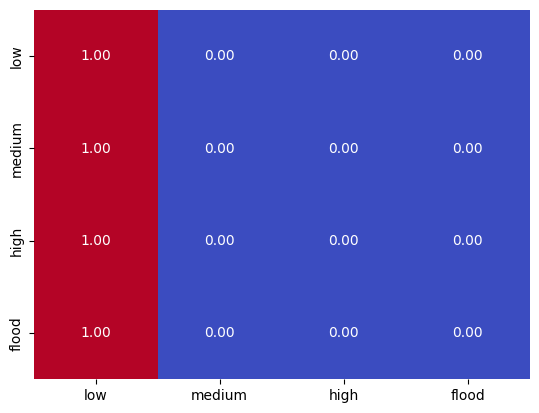


 /models/single_rgb_v1


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy
Mean: 0.9890870570007655 , Std: 0.0026106963321152034
Balanced accuracy
Mean: 0.25 , Std: 0.0
Precision macro
Mean: 0.24727176425019137 , Std: 0.0006526740830288009
Recall macro
Mean: 0.25 , Std: 0.0
F1 macro
Mean: 0.24862796547441393 , Std: 0.00032955461620516477
F1 micro
Mean: 0.9890870570007655 , Std: 0.0026106963321152034


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


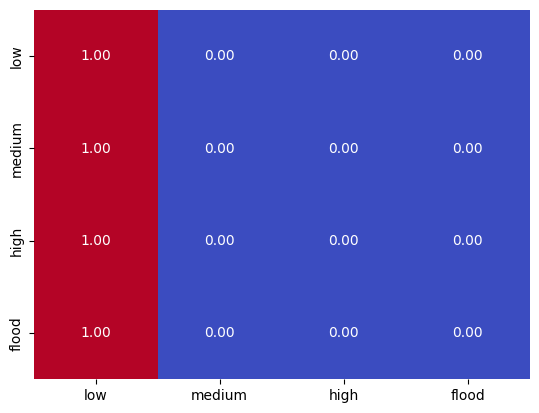


 /models/single_gray_flow_v0


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy
Mean: 0.9890806832949095 , Std: 0.002511393465124915
Balanced accuracy
Mean: 0.25 , Std: 0.0
Precision macro
Mean: 0.24727017082372738 , Std: 0.0006278483662812287
Recall macro
Mean: 0.25 , Std: 0.0
F1 macro
Mean: 0.24862719224464655 , Std: 0.00031703991883200633
F1 micro
Mean: 0.9890806832949095 , Std: 0.002511393465124915


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


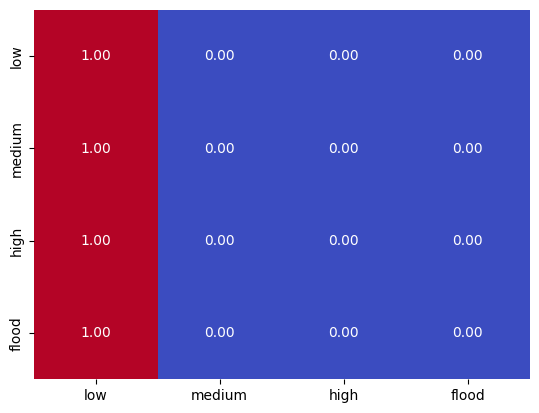


 /models/stack_flow_v0


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy
Mean: 0.9864648942647614 , Std: 0.001968392171041446
Balanced accuracy
Mean: 0.25 , Std: 0.0
Precision macro
Mean: 0.24661622356619034 , Std: 0.0004920980427603615
Recall macro
Mean: 0.25 , Std: 0.0
F1 macro
Mean: 0.24829633680917068 , Std: 0.0002492829293892403
F1 micro
Mean: 0.9864648942647614 , Std: 0.001968392171041446


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


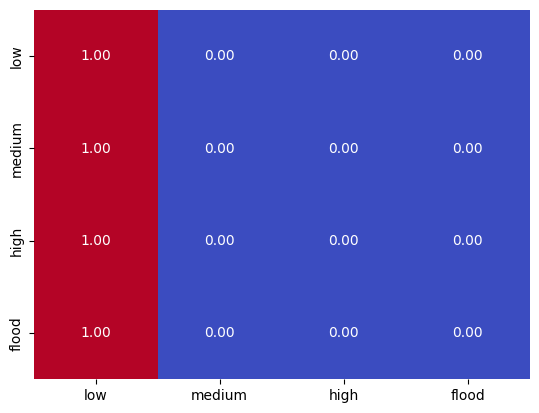

In [8]:
eval_all(base_paths, lbl_names=lbl_names, dummy_strategy='prior')

# Evaluating models that classify changes to the water level

Below, I evaluate the models aimed at, given a pair of input images or a sequence of such pairs, identify if the water level is stable, if it is increasing, or if it is decreasing.
So far, the classes are *up*, *down*, and *still*.

In [9]:
base_paths = list()
base_paths.append('/models/single_flow_diffs_v0')
base_paths.append('/models/single_gray_flow_diffs_v0')
base_paths.append('/models/stack_flow_diffs_v0')
base_paths.append('/models/pair_gray_diffs_v0')


 /models/single_flow_diffs_v0
Accuracy
Mean: 0.9684195872005404 , Std: 0.011021095401507848
Balanced accuracy
Mean: 0.8059583107859892 , Std: 0.081274736876028
Precision macro
Mean: 0.3943965360720863 , Std: 0.019000180215439703
Recall macro
Mean: 0.8059583107859892 , Std: 0.081274736876028
F1 macro
Mean: 0.4360744195295928 , Std: 0.033193047390634924
F1 micro
Mean: 0.9684195872005404 , Std: 0.011021095401507848


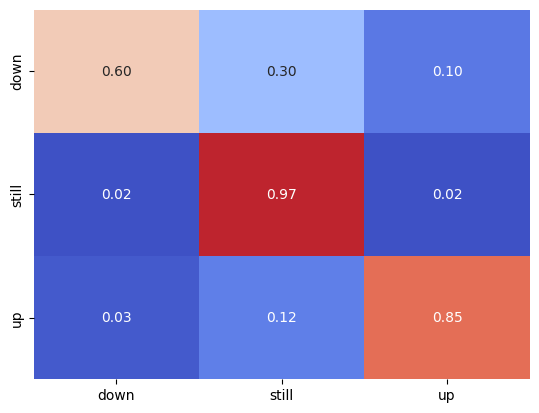


 /models/single_gray_flow_diffs_v0
Accuracy
Mean: 0.9607613966331306 , Std: 0.011017122352356662
Balanced accuracy
Mean: 0.7141943889300738 , Std: 0.10903554358762857
Precision macro
Mean: 0.37723826924394127 , Std: 0.02022764624292656
Recall macro
Mean: 0.7141943889300738 , Std: 0.10903554358762857
F1 macro
Mean: 0.4054671361844761 , Std: 0.036274951827149994
F1 micro
Mean: 0.9607613966331306 , Std: 0.011017122352356662


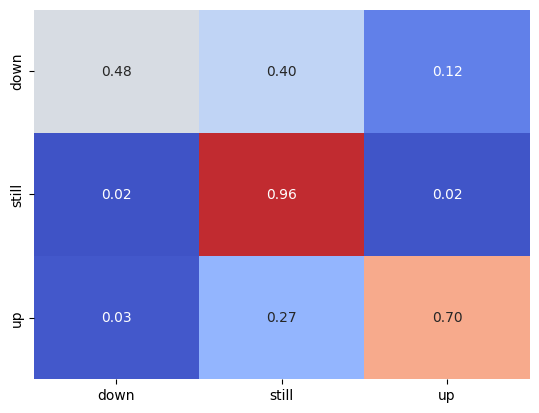


 /models/stack_flow_diffs_v0
Accuracy
Mean: 0.9730368663526555 , Std: 0.007318274986442864
Balanced accuracy
Mean: 0.8110254817831833 , Std: 0.04548824040388477
Precision macro
Mean: 0.4898327548885775 , Std: 0.03315927500467671
Recall macro
Mean: 0.8110254817831833 , Std: 0.04548824040388477
F1 macro
Mean: 0.563605757059601 , Std: 0.04025822560413861
F1 micro
Mean: 0.9730368663526554 , Std: 0.007318274986442839


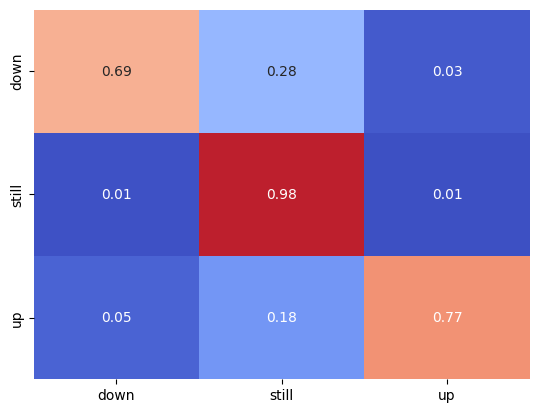


 /models/pair_gray_diffs_v0
Accuracy
Mean: 0.981880919893058 , Std: 0.006006861527120195
Balanced accuracy
Mean: 0.7442190589593137 , Std: 0.1611190230524627
Precision macro
Mean: 0.42800372020753347 , Std: 0.018661187152255315
Recall macro
Mean: 0.7442190589593137 , Std: 0.1611190230524627
F1 macro
Mean: 0.4761832459391913 , Std: 0.03005158959220305
F1 micro
Mean: 0.981880919893058 , Std: 0.006006861527120195


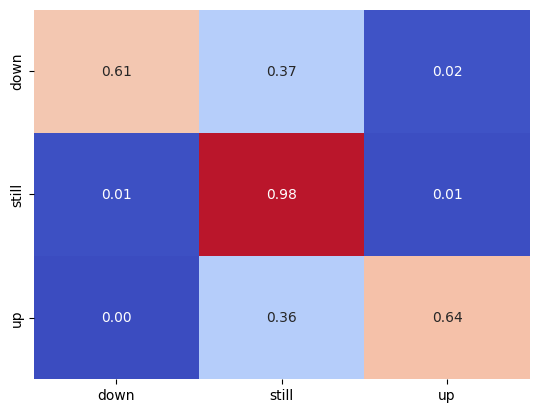

In [10]:
lbl_names = ['down', 'still', 'up']
eval_all(base_paths, lbl_names=lbl_names)

## Dummy classifiers


 /models/single_flow_diffs_v0
Accuracy
Mean: 0.9962205480811681 , Std: 0.000590735748925158
Balanced accuracy
Mean: 0.3333333333333333 , Std: 0.0
Precision macro
Mean: 0.33207351602705604 , Std: 0.00019691191630838412
Recall macro
Mean: 0.3333333333333333 , Std: 0.0
F1 macro
Mean: 0.3327022028171166 , Std: 9.885759647760516e-05
F1 micro
Mean: 0.9962205480811681 , Std: 0.000590735748925158


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

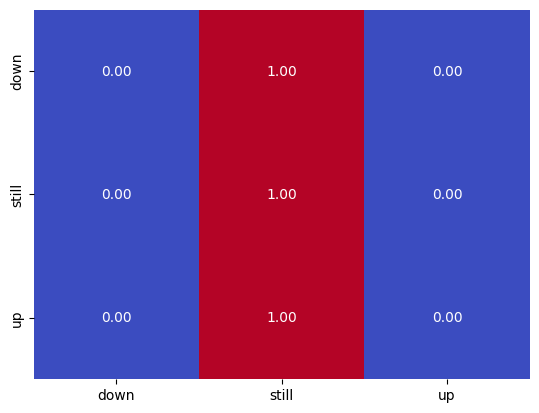


 /models/single_gray_flow_diffs_v0


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy
Mean: 0.9962205480811681 , Std: 0.000590735748925158
Balanced accuracy
Mean: 0.3333333333333333 , Std: 0.0
Precision macro
Mean: 0.33207351602705604 , Std: 0.00019691191630838412
Recall macro
Mean: 0.3333333333333333 , Std: 0.0
F1 macro
Mean: 0.3327022028171166 , Std: 9.885759647760516e-05
F1 micro
Mean: 0.9962205480811681 , Std: 0.000590735748925158


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


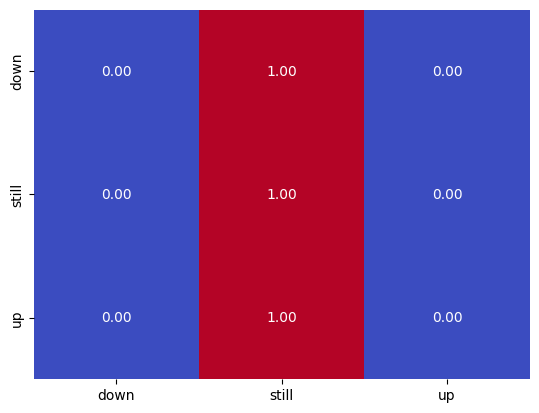


 /models/stack_flow_diffs_v0


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy
Mean: 0.9903592315101389 , Std: 0.0007688714141738662
Balanced accuracy
Mean: 0.3333333333333333 , Std: 0.0
Precision macro
Mean: 0.330119743836713 , Std: 0.00025629047139129037
Recall macro
Mean: 0.3333333333333333 , Std: 0.0
F1 macro
Mean: 0.3317187057130352 , Std: 0.00012940121673677327
F1 micro
Mean: 0.9903592315101389 , Std: 0.0007688714141738662


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


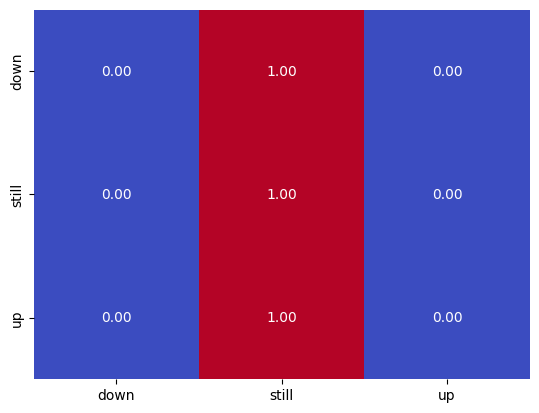

In [12]:
eval_all(base_paths, lbl_names=lbl_names, dummy_strategy='prior')